# Demo - Offensive Metrics in Baseball

This demo will explore how metrics for quantifying team run scoring performance.  We will look at the classical slash line statistics and get a feel for how they work.  We will then look at how effective they are at measuring performance.  We will then look at two advanced metrics and how these metrics improve on the classical statistics.  

The demo shows how we should think about evaluating metrics and provide motivation for exploring the construction process for building the advanced metrics.

For this demo, we assume the user is familiar with the usual acronyms, shorthand abbreviations, and definitions of commonly used categories in baseball like BA for Batting Average, 1B for singles, and PA for plate appearances. 

In [1]:
# Setup
%run ../../utils/notebook_setup.py

from datascience import Table
import numpy as np

# custom functions that will help do some simple tasks
from datascience_utils import *
from datascience_stats import *

Adding datascience helper tools to path...
Setting up Matplotlib...
Matplotlib imported as mpl
Matplotlib.pyplot imported as plt


## 1. The Slash Line

We're going to study the classical baseball statistics that have been used extensively over the years.

The classical baseball statistics are _Batting Average_, _On-Base Percentage_, and _Slugging Percentage_, which make up what is commonly known as a batters _Slash Line_ due to how the stats are displayed in order with a "/" between them.  

In [2]:
# Load lahman_teams.csv obtained from the Lahman databank.  We only need a selection of the columns.
lahman = Table.read_table("lahman_teams.csv", usecols=[0, 3, 6, 8, 9] + list(range(14, 28)))

# Compute runs per game
lahman['Rpg'] = lahman['R'] / lahman['G']
lahman.show(5)

yearID,franchID,G,W,L,R,AB,H,2B,3B,HR,BB,SO,SB,CS,HBP,SF,RA,ER,Rpg
1871,BNA,31,20,10,401,1372,426,70,37,3,60,19,73,nan,nan,nan,303,109,12.9355
1871,CNA,28,19,9,302,1196,323,52,21,10,60,22,69,nan,nan,nan,241,77,10.7857
1871,CFC,29,10,19,249,1186,328,35,40,7,26,25,18,nan,nan,nan,341,116,8.58621
1871,KEK,19,7,12,137,746,178,19,8,2,33,9,16,nan,nan,nan,243,97,7.21053
1871,NNA,33,16,17,302,1404,403,43,21,1,33,15,46,nan,nan,nan,313,121,9.15152


After loading the dataset we need to perform a few extra operations:
+ We restrict to year 1940 and later.  
+ The dataset does not contain a field for singles so this is easy to compute from the available data as $H - \mathit{2B} - \mathit{3B} - \mathit{HR}$
+ Some fields like $\mathit{HBP}$ are not guaranteed to be recorded in the dataset.  We'll fill in those values as 0 even though we know it shouldn't be zero.  We have no better option right now.
+ Finally, we need to add plate appearances.  The quantity is only an approximate value for PA.  The reason is that there are other baseball events that occur but one unfortunate limitation of the Lahman Database is that it can sometimes have holes like this.

In [3]:
# First we'll restrict to after the year 1940
lahman = lahman.where(lahman['yearID'] >= 1940).copy()

We want the years in five year periods so we use a helper function

In [4]:
# bucket by five year increments
lahman['year5'] = floor_to_nearest(lahman['yearID'], 5) 

Unfortunately there are some null values because some statistics weren't reliably recorded previously.  We'll fill those with 0s.

In [5]:
# fill in null values
lahman['HBP'] = fill_null(lahman, fill_column='HBP', fill_value=0)
lahman['SF'] = fill_null(lahman, fill_column='SF', fill_value=0)
lahman['CS'] = fill_null(lahman, fill_column='CS', fill_value=0)

We also need to add two fields: singles and PA (which is only approximate)

In [6]:
# compute some missing columns
lahman['1B'] = lahman['H'] - lahman['2B'] - lahman['3B'] - lahman['HR']
lahman['PA'] = lahman['AB'] + lahman['BB'] + lahman['HBP'] + lahman['SF']

### Computing the Slash Line

Using the formula for BA, OBP, and SLG, we add the classical stats to the table.

In [7]:
# Batting Average
lahman['BA'] = lahman['H'] / lahman['AB']
# On-Base Percentage
lahman['OBP'] = (lahman['H'] + lahman['BB'] + lahman['HBP']) / lahman['PA']
# Slugging Percentage
lahman['SLG'] = (lahman['1B'] + 2 * lahman['2B'] +
                 3 * lahman['3B'] + 4 * lahman['HR']) / lahman['AB']

### Histograms

We can visualize the typical team values for the stats to get a feel for what we can expect from teams.  Team values will be inherently more concentrated than player values since teams are made up of an assortment of player ability levels.  For instance, only one team since 1940 has had a BA over .300 yet many players have.  Ted Williams had a BA over .400!

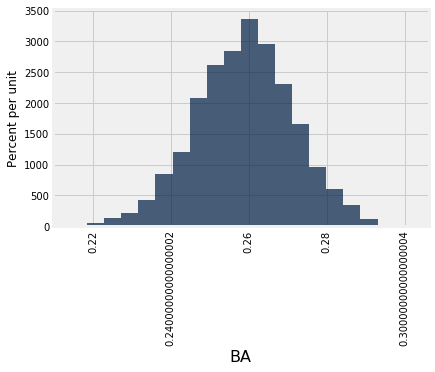

In [8]:
lahman.hist('BA', bins=20)

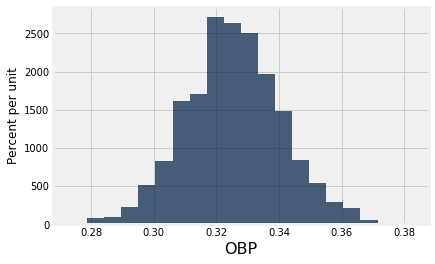

In [9]:
lahman.hist('OBP', bins=20)

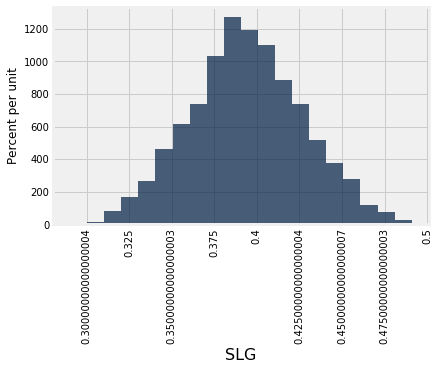

In [10]:
lahman.hist('SLG', bins=20)

### Historical Trends/Cycles

We can also see how team values change over time according to various eras in baseball.

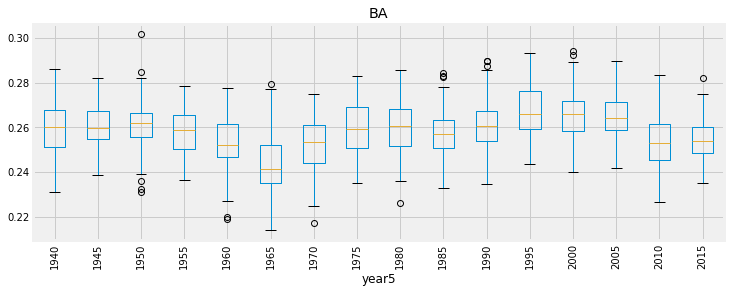

In [11]:
boxplots(lahman, column='BA', by='year5', figsize=(12, 4), rot=90)

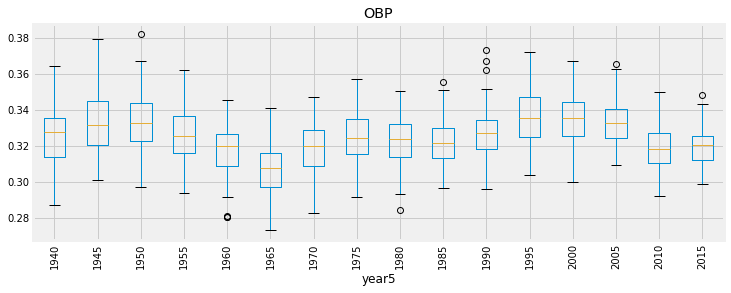

In [12]:
boxplots(lahman, column='OBP', by='year5', figsize=(12, 4), rot=90)

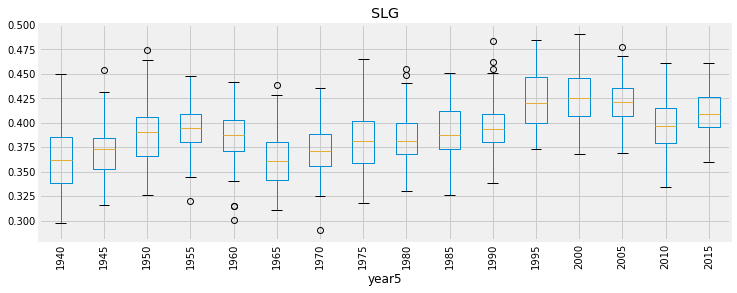

In [13]:
boxplots(lahman, column='SLG', by='year5', figsize=(12, 4), rot=90)

### Best and Worst Teams

#### Batting Average

In [14]:
lahman.sort('BA').\
    select('yearID', 'franchID', 'G', 'W', 'L', 'R', 'Rpg', 'BA').\
    show(10)

yearID,franchID,G,W,L,R,Rpg,BA
1968,NYY,164,83,79,536,3.26829,0.214124
1972,TEX,154,54,100,461,2.99351,0.217141
1963,NYM,162,51,111,501,3.09259,0.218891
1963,HOU,162,66,96,464,2.8642,0.219911
1965,NYM,164,50,112,495,3.01829,0.220915
1967,TEX,161,76,85,550,3.41615,0.222569
1968,TEX,161,65,96,524,3.25466,0.223704
1969,SDP,162,52,110,468,2.88889,0.224566
1967,CHW,162,89,73,531,3.27778,0.224596
1972,NYM,156,83,73,528,3.38462,0.224732


In [15]:
lahman.sort('BA', descending=True).\
    select('yearID', 'franchID', 'G', 'W', 'L', 'R', 'Rpg', 'BA').\
    show(10)

yearID,franchID,G,W,L,R,Rpg,BA
1950,BOS,154,94,60,1027,6.66883,0.301849
2000,COL,162,82,80,968,5.97531,0.293993
1996,CLE,161,99,62,952,5.91304,0.293082
1999,TEX,162,95,67,945,5.83333,0.292515
2001,COL,162,73,89,923,5.69753,0.292267
1997,BOS,162,78,84,851,5.25309,0.291299
1998,COL,162,77,85,826,5.09877,0.291193
1995,CLE,144,100,44,840,5.83333,0.290573
1994,NYY,113,70,43,670,5.9292,0.289764
2007,NYY,162,94,68,968,5.97531,0.289662


#### On-Base Percentage

In [16]:
lahman.sort('OBP').\
    select('yearID', 'franchID', 'G', 'W', 'L', 'R', 'Rpg', 'OBP').\
    show(10)

yearID,franchID,G,W,L,R,Rpg,OBP
1965,NYM,164,50,112,495,3.01829,0.273273
1968,NYM,163,73,89,473,2.90184,0.277287
1963,NYM,162,51,111,501,3.09259,0.280511
1964,HOU,162,66,96,495,3.05556,0.280612
1963,HOU,162,66,96,464,2.8642,0.280822
1968,CHW,162,67,95,463,2.85802,0.280938
1969,SDP,162,52,110,468,2.88889,0.281315
1972,SDP,153,58,95,488,3.18954,0.282562
1968,TEX,161,65,96,524,3.25466,0.283908
1981,TOR,106,37,69,329,3.10377,0.2841


In [17]:
lahman.sort('OBP', descending=True).\
    select('yearID', 'franchID', 'G', 'W', 'L', 'R', 'Rpg', 'OBP').\
    show(10)

yearID,franchID,G,W,L,R,Rpg,OBP
1950,BOS,154,94,60,1027,6.66883,0.382358
1949,BOS,155,96,58,896,5.78065,0.379366
1994,NYY,113,70,43,670,5.9292,0.373118
1999,CLE,162,97,65,1009,6.2284,0.371962
1948,BOS,155,96,59,907,5.85161,0.370837
1996,CLE,161,99,62,952,5.91304,0.367758
1994,CHW,113,67,46,633,5.60177,0.3672
1950,DET,157,95,59,837,5.33121,0.367033
2000,CLE,162,90,72,950,5.8642,0.367022
2007,NYY,162,94,68,968,5.97531,0.365557


#### Slugging Percentage

In [18]:
lahman.sort('SLG').\
    select('yearID', 'franchID', 'G', 'W', 'L', 'R', 'Rpg', 'SLG').\
    show(10)

yearID,franchID,G,W,L,R,Rpg,SLG
1972,TEX,154,54,100,461,2.99351,0.290316
1943,OAK,155,49,105,497,3.20645,0.297292
1963,HOU,162,66,96,464,2.8642,0.30052
1942,PHI,151,42,109,394,2.60927,0.305929
1943,ATL,153,68,85,465,3.03922,0.308699
1968,CHW,162,67,95,463,2.85802,0.311008
1964,HOU,162,66,96,495,3.05556,0.314539
1968,NYM,163,73,89,473,2.90184,0.314919
1963,NYM,162,51,111,501,3.09259,0.315217
1945,OAK,153,52,98,494,3.22876,0.315521


In [19]:
lahman.sort('SLG', descending=True).\
    select('yearID', 'franchID', 'G', 'W', 'L', 'R', 'Rpg', 'SLG').\
    show(10)

yearID,franchID,G,W,L,R,Rpg,SLG
2003,BOS,162,95,67,961,5.9321,0.4909
1997,SEA,162,90,72,925,5.70988,0.484503
1994,CLE,113,66,47,679,6.00885,0.483839
1996,SEA,161,85,76,993,6.1677,0.483592
2001,COL,162,73,89,923,5.69753,0.482953
1995,CLE,144,100,44,840,5.83333,0.478719
1999,TEX,162,95,67,945,5.83333,0.478676
1997,COL,162,83,79,923,5.69753,0.47778
2009,NYY,162,103,59,915,5.64815,0.477562
2000,HOU,162,72,90,938,5.79012,0.476661


## 2. Classical Stats and Runs Scored

We can look at simple scatter plots between the classic stats and runs scored to see how they relate.  We will also compute some metrics that quantify the relationship but suffice to say, having higher values for these metrics will tend to increase run scoring.  The most tenuous relationship definitely appears to be batting average.

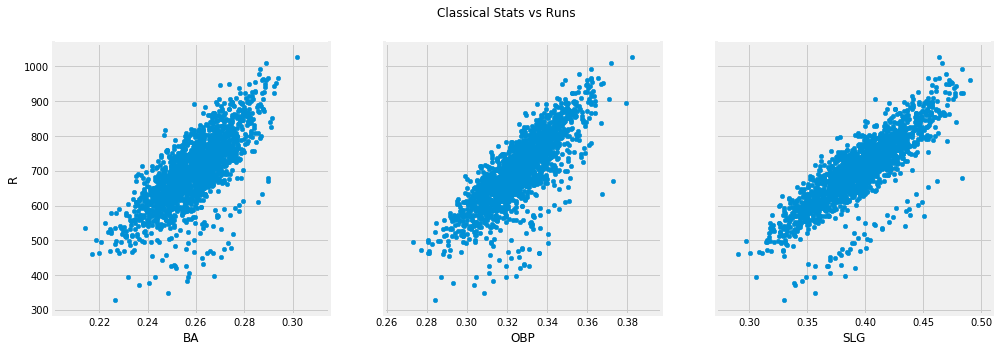

In [20]:
stats = ['BA', 'OBP', 'SLG']
scatterplot_by_x(lahman, stats, 'R', title='Classical Stats vs Runs')

Note that due to the variable number of games a team might have played, we cannot directly consider runs scored.  Instead, we use Runs per Game.

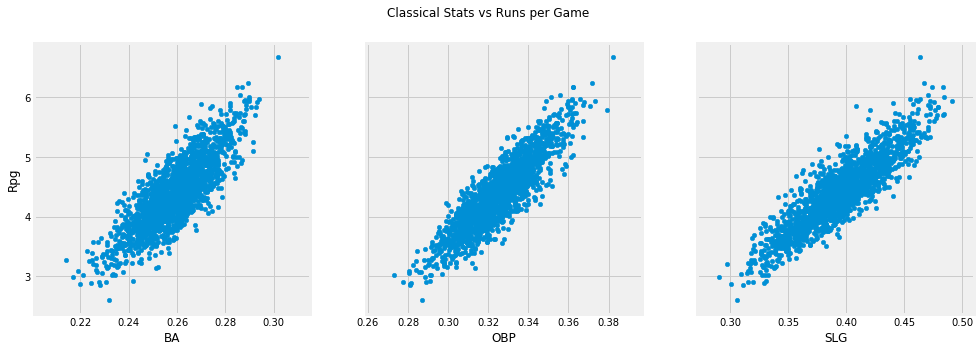

In [21]:
scatterplot_by_x(lahman, stats, 'Rpg', title='Classical Stats vs Runs per Game')

### Correlation with Team Runs

This is the most involved step of the demo.  For each of the three classical stats, we need to do four things:
1. Compute a linear relationship between Team Runs and the statistic.  For example, for Batting Average:
$$
    \text{Predicted Team Runs} = \alpha + \beta \cdot \text{Team Batting Average}
$$
Each statistic will have its own $\alpha, \beta$ value.  We are not so interested in those values but rather the predicted value of Team Runs given a Team Batting Average and its error.
2. The error of the prediction in 1:
$$
    \text{Error} = \text{Team Runs} - \text{Predicted Team Runs}
$$
3. The correlation between the statistic and Team Runs
4. Plots of the relationship between Team Runs and the statistic, the linear relationship, and the errors.


#### 1. and 2. Linear Relationship and Error

In [22]:
linear_relationships = {}

# Start a table with runs per game
linear_fits = Table().with_column('Rpg', lahman['Rpg'])

# Compute the linear fit for BA
params, predictions, error = linear_fit(lahman['BA'], lahman['Rpg'])
# add columns for BA, BA model predictions, and BA model errors
linear_fits = linear_fits.with_columns(
    'BA', lahman['BA'],
    'BA_pred', predictions,
    'BA_err', error
)
# save the slope/intercept parameters
linear_relationships['BA'] = params

# Compute the linear fit for OBP
params, predictions, error = linear_fit(lahman['OBP'], lahman['Rpg'])
# add columns for OBP, OBP model predictions, and OBP model errors
linear_fits = linear_fits.with_columns(
    'OBP', lahman['OBP'],
    'OBP_pred', predictions,
    'OBP_err', error
)
# save the slope/intercept parameters
linear_relationships['OBP'] = params

# Compute the linear fit for SLG

params, predictions, error = linear_fit(lahman['SLG'], lahman['Rpg'])
# add columns for SLG, SLG model predictions, and SLG model errors
linear_fits = linear_fits.with_columns(
    'SLG', lahman['SLG'],
    'SLG_pred', predictions,
    'SLG_err', error
)
# save the slope/intercept parameters
linear_relationships['SLG'] = params

linear_fits.show(10)

Rpg,BA,BA_pred,BA_err,OBP,OBP_pred,OBP_err,SLG,SLG_pred,SLG_err
5.66234,0.285714,5.38759,0.274746,0.355131,5.35881,0.303526,0.449188,5.23251,0.429828
4.46795,0.259781,4.42855,0.0393946,0.324266,4.35718,0.11077,0.383181,4.23142,0.236526
4.09868,0.256333,4.30107,-0.202385,0.308498,3.84548,0.253207,0.349409,3.71922,0.379461
4.74194,0.278314,5.11393,-0.371996,0.33917,4.84086,-0.0989259,0.386558,4.28264,0.4593
4.42208,0.267397,4.71019,-0.288116,0.327542,4.46351,-0.0414278,0.383559,4.23716,0.184921
4.56129,0.265637,4.64511,-0.0838217,0.322747,4.30789,0.253403,0.37863,4.1624,0.398891
4.58065,0.265249,4.63078,-0.0501327,0.330102,4.54658,0.0340666,0.39806,4.45708,0.123562
5.72903,0.285899,5.39442,0.334615,0.363861,5.6421,0.086929,0.441676,5.11858,0.610456
4.36184,0.26728,4.70589,-0.344051,0.324736,4.37244,-0.0105995,0.373591,4.08598,0.275861
5.27097,0.259364,4.41316,0.857807,0.340243,4.87566,0.395308,0.418275,4.76367,0.507302


#### 3. Correlation with Runs per Game

In [23]:
correlations = {}

# Compute the correlations of each stat with runs per game
correlations['BA'] = correlation(lahman['BA'], lahman['Rpg'])
correlations['OBP'] = correlation(lahman['OBP'], lahman['Rpg'])
correlations['SLG'] = correlation(lahman['SLG'], lahman['Rpg'])

#### 4. Plotting the results

We put together the results into a simple set of pairs of plots
+ In the first plot we show a scatter plot and the linear relationship between a statistic and team runs.  What is immediately clear is that these stats are in fact related to scoring and not complete nonsense. In fact, if they were all you had, they would be okay.  But as we will see, you can do better.
+ In the second plot, we show the errors between the actual team run values and the predicted values from the linear relationship.  We do this because we want to visually see that OBP and SLG do in fact improve on BA in terms of the size of the errors.  By tending to have smaller error, this shows OBP and SLG correlate/associate with run scoring in a stronger manner than just batting average.

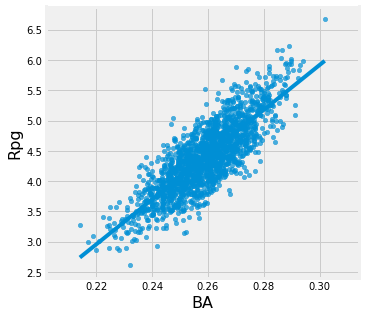

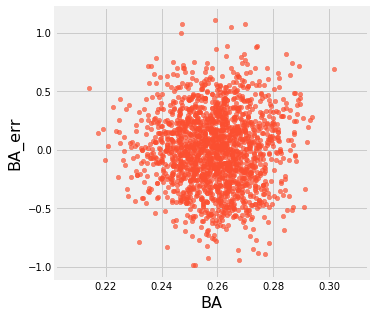

In [24]:
linear_fits.scatter('BA', select='Rpg', fit_line=True, color='C0')
linear_fits.scatter('BA', select='BA_err', color='C1')

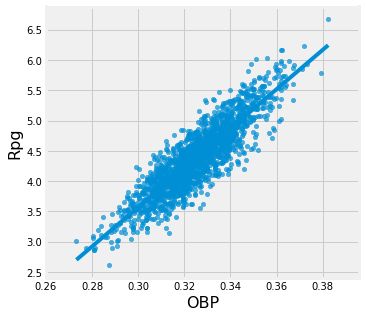

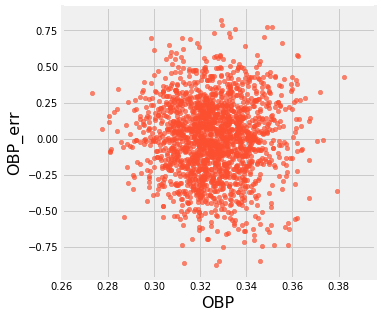

In [25]:
linear_fits.scatter('OBP', select='Rpg', fit_line=True, color='C0')
linear_fits.scatter('OBP', select='OBP_err', color='C1')

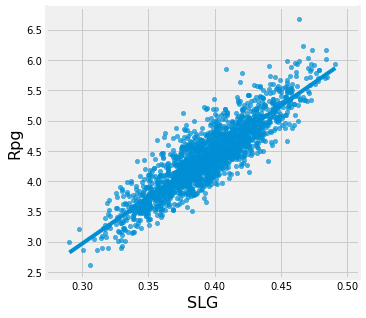

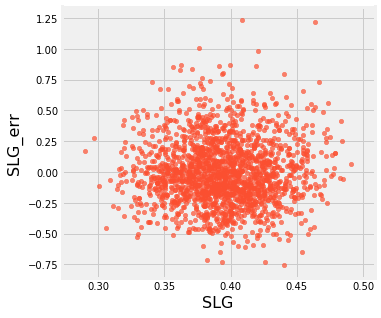

In [26]:
linear_fits.scatter('SLG', select='Rpg', fit_line=True, color='C0')
linear_fits.scatter('SLG', select='SLG_err', color='C1')

We also print out some results for each statistic.

In [27]:
def stat_summary_print(stat, corr, err_std):
    print(f"Stat: {stat}")
    print("=" * 20)
    print(f"Correlation with Runs: {corr:.3f}")
    print(f"Std dev of errors (in Runs): {err_std:.3f}")
    print()
    
# Print summaries
corr = correlations['BA']
err_std = np.std(linear_fits['BA_err'])
stat_summary_print('BA', corr, err_std)

corr = correlations['OBP']
err_std = np.std(linear_fits['OBP_err'])
stat_summary_print('OBP', corr, err_std)

corr = correlations['SLG']
err_std = np.std(linear_fits['SLG_err'])
stat_summary_print('SLG', corr, err_std)

Stat: BA
Correlation with Runs: 0.822
Std dev of errors (in Runs): 0.324

Stat: OBP
Correlation with Runs: 0.881
Std dev of errors (in Runs): 0.269

Stat: SLG
Correlation with Runs: 0.885
Std dev of errors (in Runs): 0.265



The correlation shows that OBP and SLG have a stronger link to run scoring.  The standard deviation of the prediction errors, which measures the overall magnitude of the errors (and is in the units of runs) and shows that errors are dramatically reduced by considering OBP and SLG.  A difference in standard deviation between BA and SLG of 15 runs translates to about 1.5 wins, no small matter.

_Questions_

+ If we came up with a metric that can perfectly predict team run scoring for all season post-2000, why should we be suspicious of this metric?
+ What do you think of the implicit assumption that if a metric works well in measuring team performance that it works well at the player level?  Do you have a problem with the assumpion and if so, why?  If not, give a justification for the assumption.

### Correlation Between Statistics

One thing we might wonder is since OBP and SLG are seemingly both improvements on BA, are they telling us something different?  Well, for one, based on the construction we know that has to be true.  The extra weighting of extra base hits means they cannot possibly be the same.  But to what extent are they different?  

Well, we can look at the correlations between the three statistics to see how closely they relate to each other.  We find that OBP is pretty closely linked to BA and we know that whatever difference exists there is due entirely to ignoring walks and hit py pitch events. 

SLG shows a lower correlation with either BA and OBP, clearly due to its weighting for extra base hits.

In [28]:
rho_obp_ba = correlation(lahman["OBP"], lahman['BA'])
rho_obp_slg = correlation(lahman["OBP"], lahman['SLG'])
rho_ba_slg = correlation(lahman["BA"], lahman['SLG'])

print(f" BA and OBP: {rho_obp_ba:.3f}")
print(f" BA and SLG: {rho_ba_slg:.3f}")
print(f"OBP and SLG: {rho_obp_slg:.3f}")

 BA and OBP: 0.846
 BA and SLG: 0.749
OBP and SLG: 0.710


_Question_
+ Why does it matter that OBP and SLG correlate with team runs but not completely with each other?

## 3. Advanced Statistics

### OPS

OPS stands for "On-Base Plus Slugging".  The formula for OPS is pretty obvious:
$$
    \mathit{OPS} = \mathit{OBP} + \mathit{SLG}
$$
OPS is probably the most well-known advanced metric since it is often the first foray into advanced stats for people.

As we've seen above, OBP and SLG are both good metrics for run scoring.  Because they're not perfectly correlated, we can try to combine them in some way (in this case, just adding them) and hopefully gain some extra power in measuring performance.

One thing that should be pointed out about OPS is that is adds two metrics that measure two entirely different things: times on-base per plate appearance vs. total bases per at-bat.  Therefore, the actual number coming out of OPS is meaningless other than higher is better. 

In [29]:
# Team OPS
lahman['OPS'] = lahman['OBP'] + lahman['SLG']

As before, we can visualize the typical team values for OPS to get a feel for what we can expect from teams.  Since the actual numeric value of OPS has no meaning, it's important to know what typical team OPS values are.  

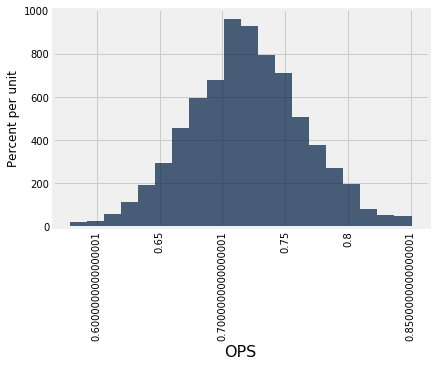

In [30]:
lahman.hist('OPS', bins=20)

### wOBA

wOBA stands for "Weighted On Base Average" and is one of the premier advanced stats out there.  It is empirically driven meaning that it was created using play-by-play baseball data and is specifically designed to perform well.  This is in contrast to BA, OBP, SLG, and OPS that were designed on intuition to measure something we had good to think mattered.  And to a large degree, BA, OBP, and SLG do measure things that matter as the above analysis showed.

The formula for wOBA is given by,
$$
    \mathit{wOBA} =
    \frac{0.72\cdot \mathit{BB} + 0.75\cdot \mathit{HBP} + 0.90\cdot \mathit{1B} + 1.24\cdot\mathit{2B} + 1.56\cdot\mathit{3B} + 1.95\cdot\mathit{HR}}{\mathit{PA}}
$$
Notice how wOBA values events differently but in different proportion from SLG.  A HR is only worth about 2.2x as much as a single instead of 4x as in SLG.  We'll dive into why wOBA doesn't weight HR as strongly but the main point is that it's actually the data telling us not to weight HR as strongly compared to a (sort of) arbitrary choice to weight using the number of bases for the hit.  

Also notice also that BB and HBP are worth not quite as much as a single.  This is actually pretty easy to grasp: we naturally prefer (and thus weight more heavily) a single to a walk because while both events leave you at first, a single puts the ball in play and therefore can lead to more advancement of runners and thus more scoring.  

In [31]:
# Team wOBA
lahman['wOBA']= (
    .72 * lahman['BB'] + .75 * lahman['HBP'] + 
    .9 * lahman['1B'] + 1.24 * lahman['2B'] +  
    1.56 * lahman['3B'] + 1.95 * lahman['HR']
) / lahman['PA']

You may notice with wOBA that it appears to be very similar in scale to OBP.  In fact, that is by design: a typical good OBP for a player or a team is also a typical good wOBA value.  Ditto for bad OBP values.

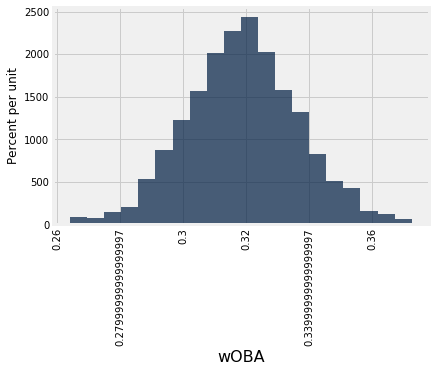

In [32]:
lahman.hist('wOBA', bins=20)

### Advanced Stats and Runs Scored

1. We'll reuse the previous correlation and linear fit analysis for BA, OBP, and SLG and compute the corresponding quantities for OPS and wOBA.
2. Then we'll generate the same scatter plots of OPS and wOBA vs Runs Scored as well as the scatter plots on the errors.
3. We'll use the `stat_summary_print` function to print out the results
4. Finally, we'll generate the correlation between wOBA and OPS

#### 1. and 2. Linear Relationship and Error

In [33]:
# Compute the linear fit for OPS
params, predictions, error = linear_fit(lahman['OPS'], lahman['Rpg'])
# add columns for OPS, OPS model predictions, and OPS model errors
linear_fits = linear_fits.with_columns(
    'OPS', lahman['OPS'],
    'OPS_pred', predictions,
    'OPS_err', error
)
# save the slope/intercept parameters
linear_relationships['OPS'] = params

# Compute the linear fit for wOBA
params, predictions, error = linear_fit(lahman['wOBA'], lahman['Rpg'])
# add columns for wOBA, wOBA model predictions, and wOBA model errors
linear_fits = linear_fits.with_columns(
    'wOBA', lahman['wOBA'],
    'wOBA_pred', predictions,
    'wOBA_err', error
)
# save the slope/intercept parameters
linear_relationships['wOBA'] = params

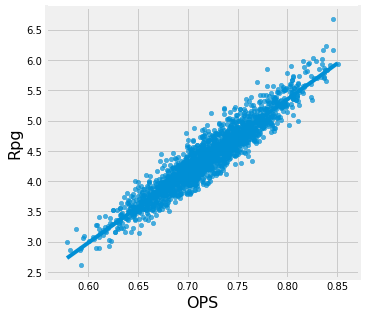

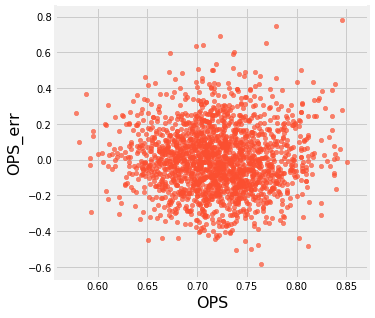

In [34]:
stat = 'OPS'
linear_fits.scatter(stat, select='Rpg', fit_line=True, color='C0')
linear_fits.scatter(stat, select=stat + '_err', color='C1')

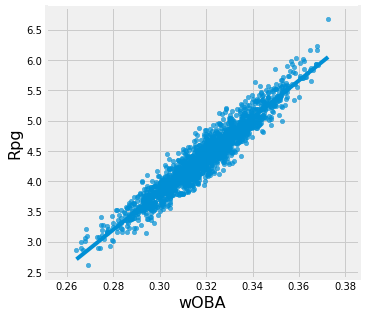

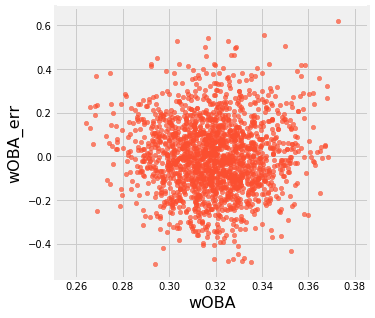

In [35]:
stat = 'wOBA'
linear_fits.scatter(stat, select='Rpg', fit_line=True, color='C0')
linear_fits.scatter(stat, select=stat + '_err', color='C1')

#### 3. Correlation with Runs per Game

In [36]:
correlations = {}

# Compute the correlations of each stat with runs per game
correlations['OPS'] = correlation(lahman['OPS'], lahman['Rpg'])
correlations['wOBA'] = correlation(lahman['wOBA'], lahman['Rpg'])

# Print summary
corr = correlations['OPS']
err_std = np.std(linear_fits['OPS_err'])
stat_summary_print('OPS', corr, err_std)


# Print summary
corr = correlations['wOBA']
err_std = np.std(linear_fits['wOBA_err'])
stat_summary_print('wOBA', corr, err_std)

Stat: OPS
Correlation with Runs: 0.945
Std dev of errors (in Runs): 0.186

Stat: wOBA
Correlation with Runs: 0.955
Std dev of errors (in Runs): 0.168



### Similarity between OPS and wOBA

In [37]:
rho_ops_wOBA = correlation(lahman["OPS"], lahman['wOBA'])
print(f"wOBA and OPS: {rho_ops_wOBA:.3f}")

wOBA and OPS: 0.992


It turns out OPS and wOBA are highly correlated.  So why do we care about wOBA if we already had OPS?  The construction of wOBA is far more justified and scientific.  OPS works partly on a justification that OPB and SLG measure two different concepts and you could benefit by combining them.  But why combine them equally?  Why not weight OBP more (as empirical results have suggested)?  Other than that, it's a bit of luck OPS is the thing that works and is close to wOBA rather than some other stat that was concocted and did the same thing.

## Wrapping up

Some final questions:

+ What does our analysis say about future performance?  Does it say anything? 
+ Say a player has a .400 wOBA for a season.  What do we require of wOBA for us to be able to reliably project next season's wOBA?